# SECCIÓN 1: Importación de bibliotecas

En esta sección importamos todas las bibliotecas y funciones necesarias para el análisis y modelado de los datos. Se importan bibliotecas comunes como pandas y sklearn, así como bibliotecas más específicas para modelos de machine learning como LightGBM y XGBoost.

Además, se importan varias funciones de sklearn para el preprocesamiento de los datos, como `RobustScaler` y `OneHotEncoder`, así como para la creación de pipelines y la transformación de columnas.

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from joblib import dump, load

# SECCIÓN 2: Carga de datos y establecimiento de semilla

En esta sección cargamos el dataset que se utilizará para el análisis y modelado. Se utiliza la función `read_parquet` de pandas para cargar un archivo en formato Parquet. Tambien se establece una semilla para trabajar.

In [2]:
df = pd.read_parquet("dataset.pq")

In [35]:
seed = 42
random.seed(seed)

In [4]:
df

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0x372c,19.0,Lawyer,42903.79,3468.315833,0,4,6,1.0,9,...,1.0,1079.48,35.716618,28.0,No,34.975457,115.184984,High_spent_Medium_value_payments,NaN,0
12496,CUS_0xf16,45.0,Media_Manager,16680.35,NaN,1,1,5,4.0,1,...,8.0,897.16,41.212367,NaN,No,41.113561,70.805550,Low_spent_Large_value_payments,NaN,0
12497,CUS_0xaf61,50.0,Writer,37188.10,3097.008333,1,4,5,3.0,7,...,3.0,620.64,39.300980,30.0,No,84.205949,42.935566,High_spent_Medium_value_payments,NaN,0
12498,CUS_0x8600,29.0,Architect,20002.88,1929.906667,10,8,29,5.0,33,...,9.0,3571.70,37.140784,6.0,Yes,60.964772,34.662906,High_spent_Large_value_payments,NaN,0


# SECCIÓN 3: Limpieza y preprocesamiento de los datos

Definimos una función de preprocesamiento de los datos. La función `clean_dataset` realiza varias tareas:
1. Hace una copia del DataFrame para no modificar los datos originales.
2. Filtra los datos para excluir filas que no cumplen con ciertos criterios. Por ejemplo, filtra a las personas que tienen una edad menor a 0 o mayor a 120, que tienen un número negativo de cuentas bancarias, entre otros.
3. Convierte la columna 'occupation' a strings.
4. Excluye las filas en las que el campo 'payment_behaviour' es igual a '9#%8'.
5. En función del argumento `erase_nm`, reemplaza el valor 'NM' en la columna 'payment_of_min_amount' por 'no' o excluye las filas que contienen 'NM'.

In [5]:
def clean_dataset(df: pd.DataFrame, erase_nm: bool= True, erase_null: bool= True) -> pd.DataFrame:
    """Preprocesses the data"""
    data = df.copy()
    query_string = (
        "age > 0 and "
        "age <= 120 and "
        "num_bank_accounts >= 0 and "
        "num_of_loan >= 0 and "
        "num_of_delayed_payment >= 0 and "
        "monthly_balance >= 0"
    )
    data = data.query(query_string)
    data.loc[:, "occupation"] = data["occupation"].astype(str)
    data = data[data["payment_behaviour"] != "9#%8"]
    if erase_nm:
        data.loc[:, "payment_of_min_amount"] = data["payment_of_min_amount"].replace("NM", "no")
    else:
        data = data[df["payment_of_min_amount"] != "NM"]
    return data

Se limpia el dataset

In [6]:
df = clean_dataset(df)

Se define un pipeline donde se escalan los valores numericos y se transforman las variables categoricas a OneHot

In [7]:
# Definir las listas de características numéricas y categóricas
numeric_features = [
    "age",
    "annual_income",
    "monthly_inhand_salary",
    "num_bank_accounts",
    "num_credit_card",
    "interest_rate",
    "num_of_loan",
    "delay_from_due_date",
    "num_of_delayed_payment",
    "changed_credit_limit",
    "num_credit_inquiries",
    "outstanding_debt",
    "credit_utilization_ratio",
    "credit_history_age",
    "total_emi_per_month",
    "amount_invested_monthly",
    "monthly_balance",
]

categorical_features = ["occupation", "payment_behaviour", "payment_of_min_amount"]

# Definir los transformadores para datos numéricos y categóricos
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown= 'ignore')

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
).set_output(transform='pandas')

pipeline = Pipeline([
    ('preprocessing', preprocessor),  # Aplicar el preprocesamiento
    ('imputer', SimpleImputer(strategy='median'))  # Asegurarse de que no haya NaN
])

# SECCIÓN 4: Definición de baseline

Para definir el baseline, se hacen 2 conjuntos, uno de training y uno de testing

In [8]:
X = df.drop(columns=["credit_score"])
y = df[["credit_score"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.1, random_state= 42
)

Ahora se entrenan 8 clasificadores para definir un pipeline y elegir los mejores modelos para el entrenamiento.

In [9]:
# Preprocesar las características utilizando el preprocessor
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

# Crear una lista para almacenar los resultados de las métricas
metric_results = []

# Definir los clasificadores
classifiers = {
    "Dummy": DummyClassifier(strategy="stratified", random_state=seed),
    "Logistic Regression": LogisticRegression(random_state=seed),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),  # KNeighborsClassifier no tiene parámetro 'random_state'
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "SVM": SVC(random_state=seed),
    "Random Forest": RandomForestClassifier(random_state=seed),
    "LightGBM": LGBMClassifier(random_state=seed),
    "XGBoost": XGBClassifier(random_state=seed, eval_metric="logloss"),
}

# Iterar sobre los clasificadores
for clf_name, clf in classifiers.items():
    # Entrenar el clasificador con los conjuntos preprocesados
    clf.fit(X_train_preprocessed, y_train)
    print("Entrenando", clf_name)
    # Realizar predicciones en el conjunto de prueba
    y_pred = clf.predict(X_test_preprocessed)
    print("Entrenado", clf_name)

    # Calcular las métricas y guardar los resultados
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metric_results.append(
        {
            "Model_name": clf_name,
            "Model": clf,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
        }
        )

    # Imprimir el reporte de clasificación para cada clasificador
    print(f"Classification Report for {clf_name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 80)

# Convertir la lista de resultados de métricas a un DataFrame
metrics_df = pd.DataFrame(metric_results)

# Ordenar el DataFrame según los valores de la métrica seleccionada (por ejemplo, Accuracy)
selected_metric = "Accuracy"
sorted_metrics_df = metrics_df.sort_values(by=selected_metric, ascending=False)

print("Results sorted by", selected_metric)
display(sorted_metrics_df)


Entrenando Dummy
Entrenado Dummy
Classification Report for Dummy:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       736
           1       0.26      0.24      0.25       316

    accuracy                           0.56      1052
   macro avg       0.47      0.47      0.47      1052
weighted avg       0.55      0.56      0.56      1052

--------------------------------------------------------------------------------
Entrenando Logistic Regression
Entrenado Logistic Regression
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       736
           1       0.61      0.31      0.41       316

    accuracy                           0.73      1052
   macro avg       0.68      0.61      0.62      1052
weighted avg       0.71      0.73      0.70      1052

--------------------------------------------------------------------------------
Entrenando

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Entrenado K-Nearest Neighbors
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.76      0.85      0.81       736
           1       0.53      0.39      0.45       316

    accuracy                           0.71      1052
   macro avg       0.65      0.62      0.63      1052
weighted avg       0.69      0.71      0.70      1052

--------------------------------------------------------------------------------
Entrenando Decision Tree
Entrenado Decision Tree
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       736
           1       0.47      0.51      0.49       316

    accuracy                           0.68      1052
   macro avg       0.63      0.63      0.63      1052
weighted avg       0.69      0.68      0.69      1052

--------------------------------------------------------------------------------
Entrenando SVM
En

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Entrenando Random Forest
Entrenado Random Forest
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       736
           1       0.63      0.49      0.55       316

    accuracy                           0.76      1052
   macro avg       0.72      0.68      0.69      1052
weighted avg       0.75      0.76      0.75      1052

--------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 2741, number of negative: 6722
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 9463, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289654 -> initscore=-0.897063
[LightGBM] [Info] Start training from score -0.897063
Entrenan

,Model_name,Model,Accuracy,Precision,Recall,F1-score
6,LightGBM,LGBMClassifier(random_state=42),0.769962,0.642308,0.528481,0.579861
7,XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.765209,0.631179,0.525316,0.573402
5,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.760456,0.629032,0.493671,0.553191
1,Logistic Regression,LogisticRegression(random_state=42),0.733840,0.612500,0.310127,0.411765
2,K-Nearest Neighbors,KNeighborsClassifier(n_jobs=-1),0.711977,0.528139,0.386076,0.446069
4,SVM,SVC(random_state=42),0.699620,0.000000,0.000000,0.000000
3,Decision Tree,DecisionTreeClassifier(random_state=42),0.682510,0.473529,0.509494,0.490854
0,Dummy,"DummyClassifier(random_state=42, strategy='str...",0.561787,0.255892,0.240506,0.247961


Se observa que, en términos de precisión, todos los clasificadores superan al clasificador Dummy, lo que demuestra que no se limitan a realizar suposiciones aleatorias. El clasificador más efectivo es el LightGBM, que logra una precisión del 0.78. La superioridad de LightGBM sobre otros clasificadores puede atribuirse a su naturaleza como modelo de ensamble, lo que le permite combinar múltiples modelos para generar una predicción final más precisa.

En la sección siguiente, se implementará una búsqueda de cuadrícula junto con un método para equilibrar las clases, con el objetivo de identificar los parámetros óptimos. Para optimizar el tiempo de procesamiento de la búsqueda de cuadrícula, se utilizarán solo dos modelos: LightGBM y XGBoost, los cuales demostraron tener las mejores métricas en el pipeline.

# SECCIÓN 5: Entrenamiento con los mejores modelos y tuning de hiperparametros

Se crea un nuevo pipeline, el cual contempla diversos casos para ambos tipos de datos. Ademas se incluye un metodo de sub\over sampling al modelo para que las clases esten balanceadas.

In [10]:
# Definir los transformadores para datos numéricos y categóricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown= 'ignore'))
])

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# Definir el resampler
resampler = SMOTE()

# Crear el pipeline de entrenamiento
train_pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('sampler', resampler),
    ('model', LGBMClassifier(verbose = -1))
])

Definimos una grilla que contemple ambos modelos definidos anteriormente con multiples parametros. Tanto en terminos de sampleo como hiperparametros del modelo

In [11]:
param_grid = [
    # grilla 1: LightGBM
    {
        'preprocessing__num__imputer__strategy': ['median', 'mean', 'most_frequent'],
        'preprocessing__cat__onehot__handle_unknown': ['infrequent_if_exist','ignore'],
        'sampler': [RandomUnderSampler(), SMOTE(k_neighbors=2), None],
        "model": [LGBMClassifier(random_state=seed, verbose= -1)],
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__n_estimators': [100, 500, 1000],
        'model__num_leaves': [31, 50, 100],
    },
    # grilla 2: XGBoost
    {
        'preprocessing__num__imputer__strategy': ['median', 'mean', 'most_frequent'],
        'preprocessing__cat__onehot__handle_unknown': ['infrequent_if_exist','ignore'],
        'sampler': [RandomUnderSampler(), SMOTE(k_neighbors=2), None],
        "model": [XGBClassifier(random_state=seed, eval_metric='mlogloss')],
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [10, 20, None],
        'model__learning_rate': [0.1, 0.01],
        'model__min_child_weight': [1, 3, 5],
        'model__subsample': [0.8, 1.0],
    },
]

Se definen los parametros del grid_search, donde nos quedamos con la mejor balanced accuracy al ser este un problema con desbalanceo. 

In [12]:
search = HalvingGridSearchCV(
    train_pipeline,
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    verbose=1,
    n_jobs=-1,
    min_resources= 100,
)

In [13]:
TRAIN = False

if TRAIN:
    search.fit(X_train, y_train)
    dump(search.best_estimator_, 'best_model.joblib') 

In [14]:
# Cargar el modelo
best_model = load('best_model.joblib') 

In [15]:

# Get the best parameters
#best_params = search.best_params_

# Get the best score
#best_score = search.best_score_

#print("Best parameters:", best_params)
#print("Best score:", best_score)


Tomando los mejores parámetros, se hacen los cambios, se entrena y se hace un classification report:

In [16]:
# Definir los transformadores para datos numéricos y categóricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown= 'infrequent_if_exist'))
])

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


# Definir el resampler
resampler = RandomUnderSampler()

# Crear el pipeline de entrenamiento
train_pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('sampler', resampler),
    ('model', XGBClassifier(
        learning_rate=0.01,
        max_depth=10,
        min_child_weight=3,
        n_estimators=200,
        subsample=0.8,
        random_state=seed
    ))
])

# Entrenar el modelo
best_model_xgb = train_pipeline.fit(X_train, y_train)

y_pred = best_model_xgb.predict(X_test)

report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       736
           1       0.55      0.69      0.61       316

    accuracy                           0.74      1052
   macro avg       0.70      0.72      0.71      1052
weighted avg       0.76      0.74      0.74      1052



# SECCIÓN 6: interpretabilidad

In [17]:
result = permutation_importance(best_model_xgb, X_test, y_test, n_repeats=30, random_state=seed)

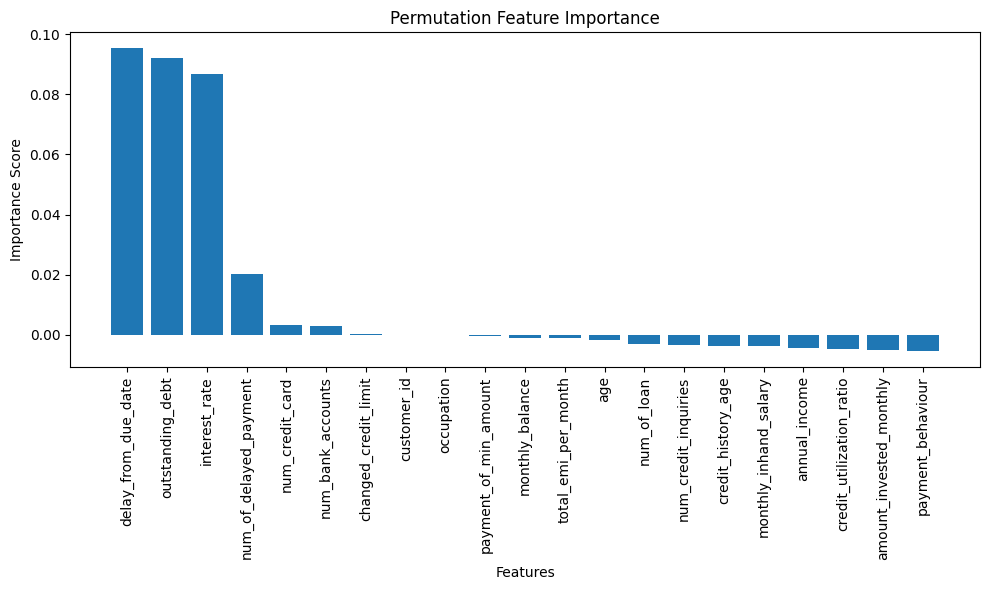

In [18]:
importance_scores = result.importances_mean
feature_names = X_test.columns

# Ordenar las características y las puntuaciones de importancia de forma descendente
sorted_indices = importance_scores.argsort()[::-1]
sorted_scores = importance_scores[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_scores)), sorted_scores)
plt.xticks(range(len(sorted_scores)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

In [55]:
xgboost_model = best_model_xgb.named_steps['model']
xgboost_model.fit(X_train_preprocessed, y_train)
explainer = shap.TreeExplainer(xgboost_model)

onehot_encoder = preprocessor.named_transformers_["cat"]["onehot"]
encoded_feature_names = onehot_encoder.get_feature_names_out(input_features=categorical_features)
transformed_column_names = numeric_features + encoded_feature_names.tolist()

df_transformed = pd.DataFrame(X_train_preprocessed, columns=transformed_column_names)
shap_values = explainer(df_transformed)


In [56]:
shap_values.values

array([[ 0.00135026,  0.09041641,  0.075453  , ..., -0.00081925,
         0.00252427, -0.00293674],
       [ 0.0324588 , -0.02231961,  0.03427975, ...,  0.00618066,
         0.00665097, -0.00221892],
       [-0.03301544,  0.0287885 , -0.02675717, ..., -0.00070195,
        -0.01154016, -0.0007138 ],
       ...,
       [-0.04069265,  0.01598882,  0.00575314, ..., -0.00100527,
        -0.01109554, -0.00081281],
       [-0.00814061, -0.02045579, -0.01294597, ..., -0.00213232,
        -0.00025243, -0.00244431],
       [-0.00626854, -0.01188003, -0.01187433, ..., -0.0083572 ,
        -0.00597302, -0.00212797]], dtype=float32)

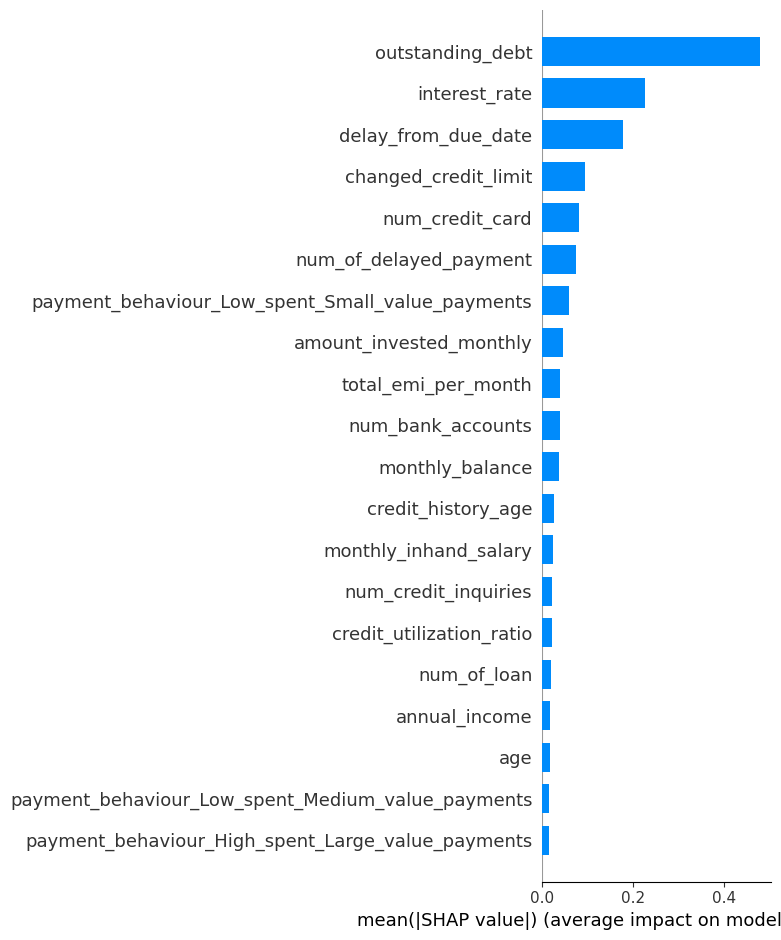

In [57]:
shap.summary_plot(shap_values, X_train_preprocessed, plot_type="bar")

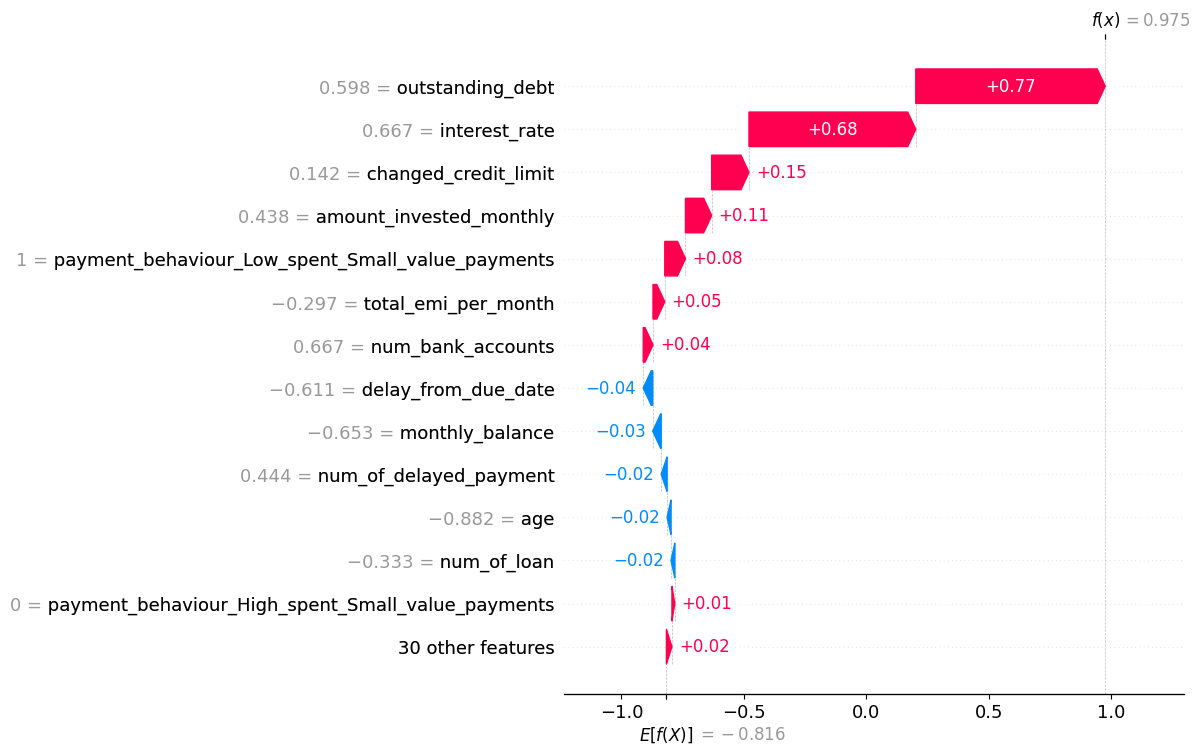

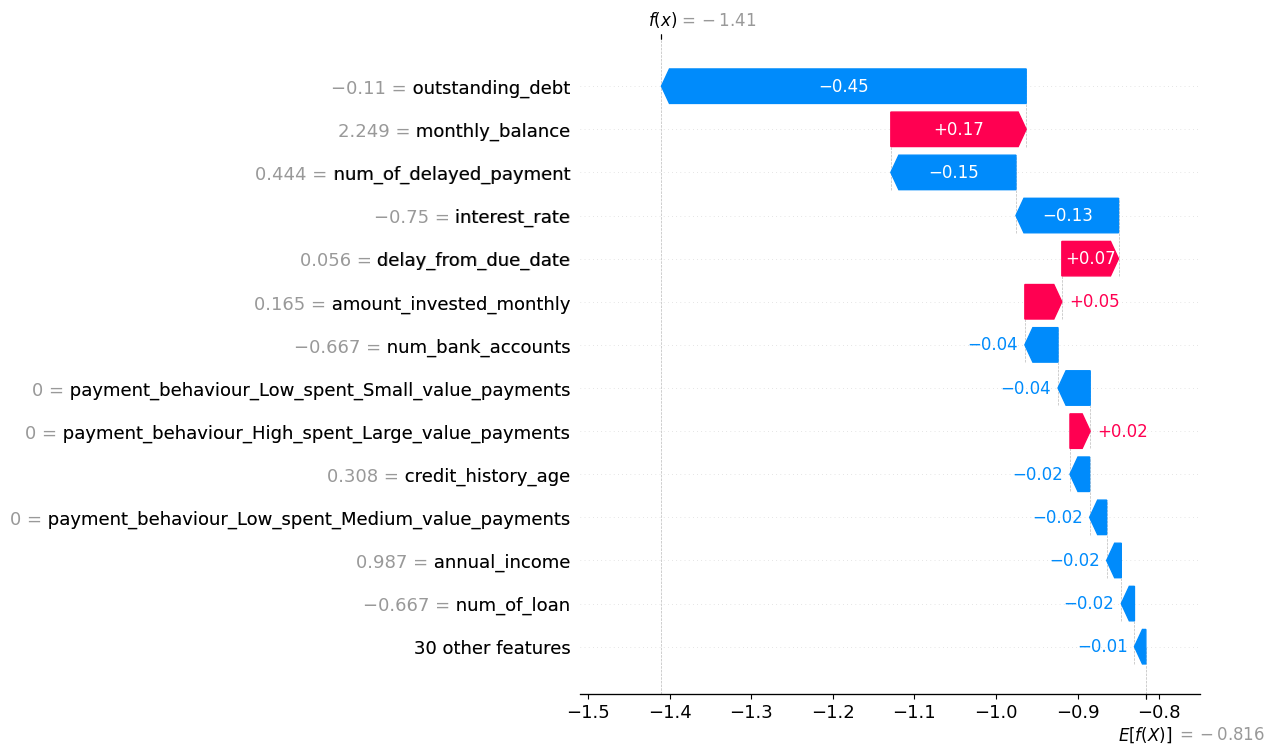

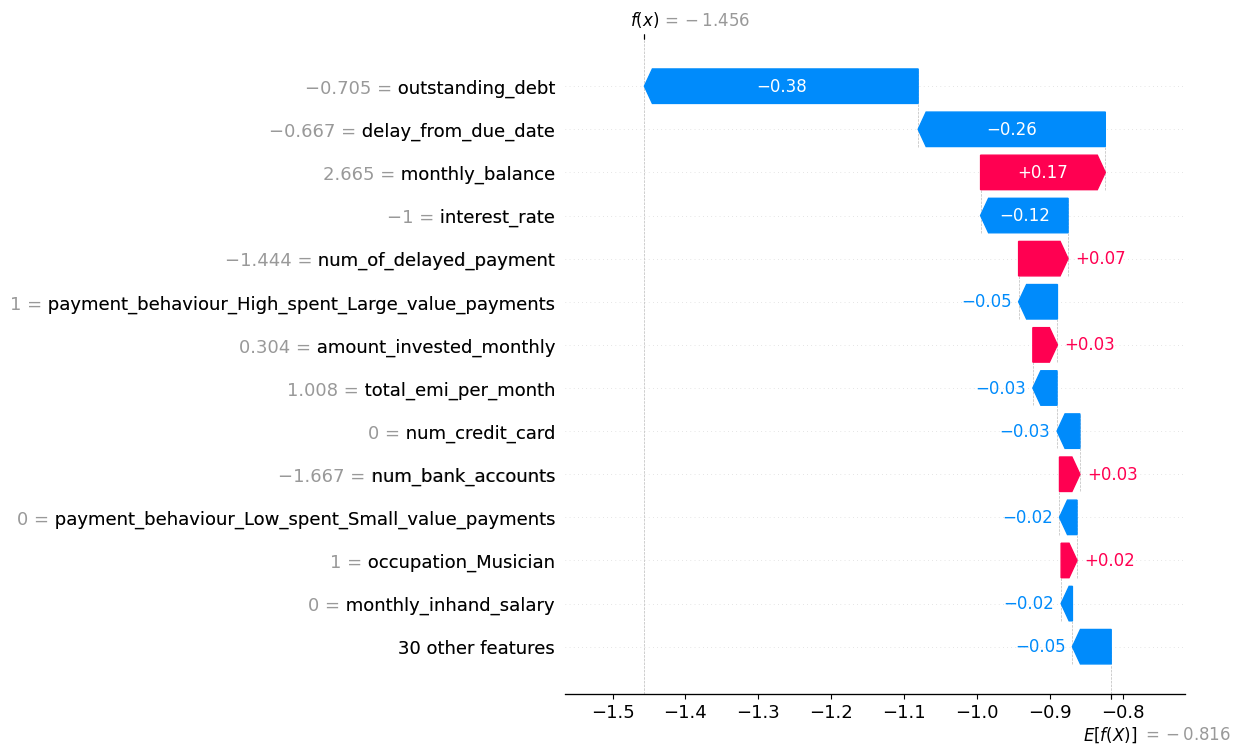

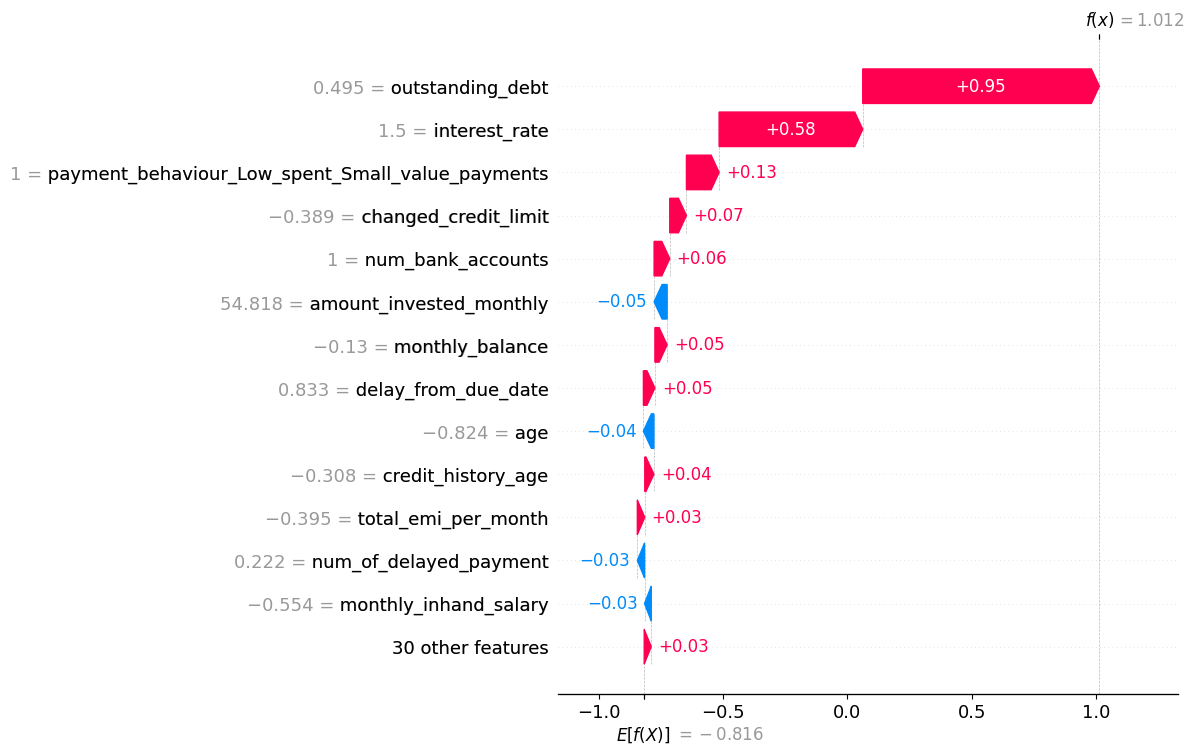

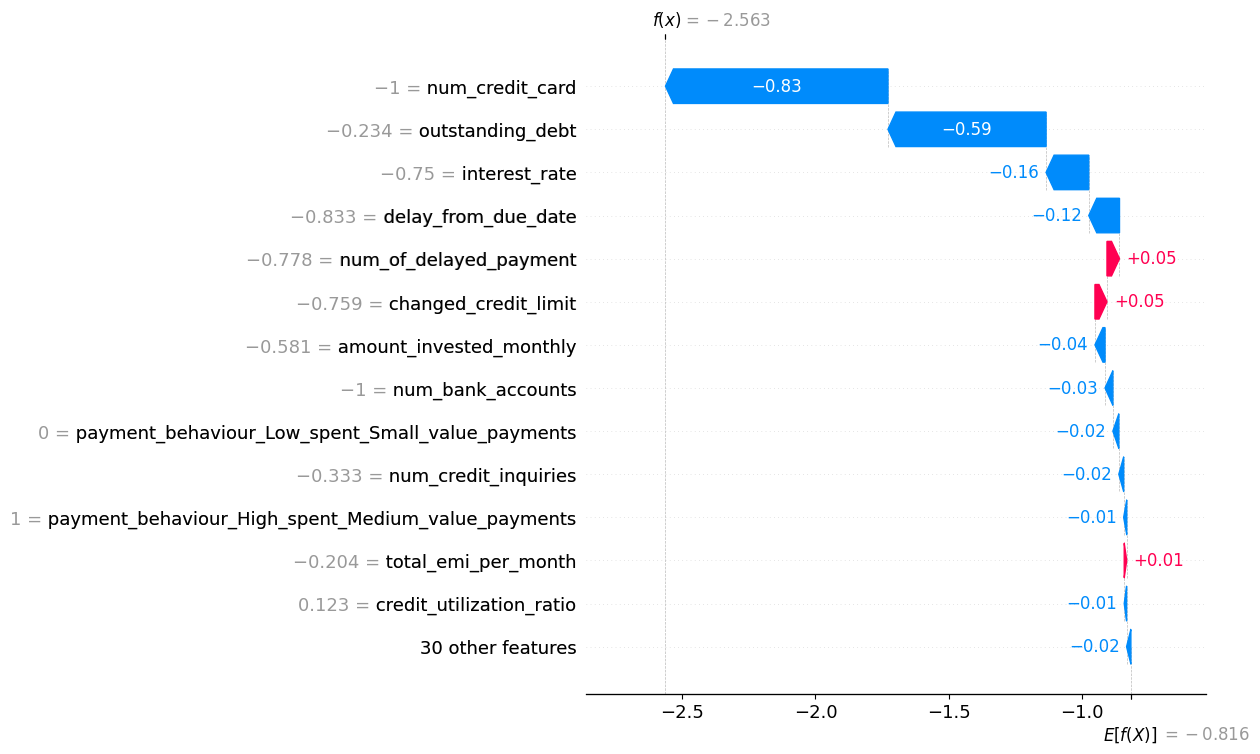

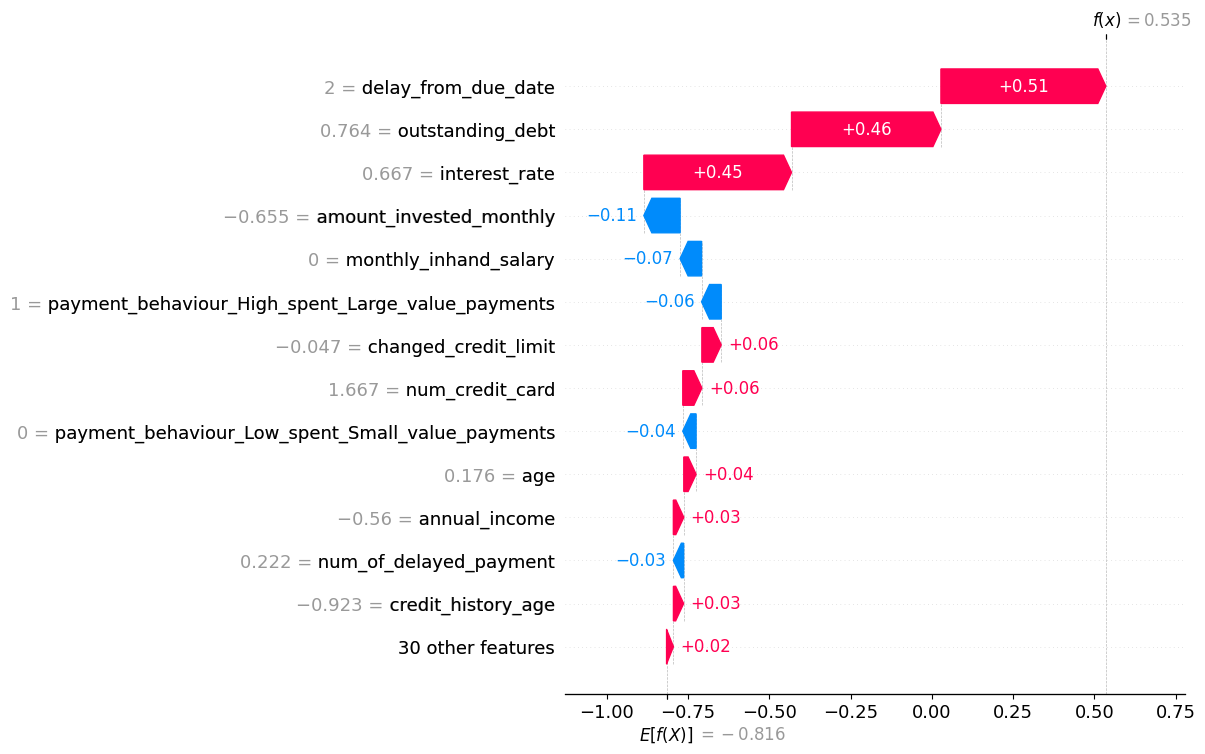

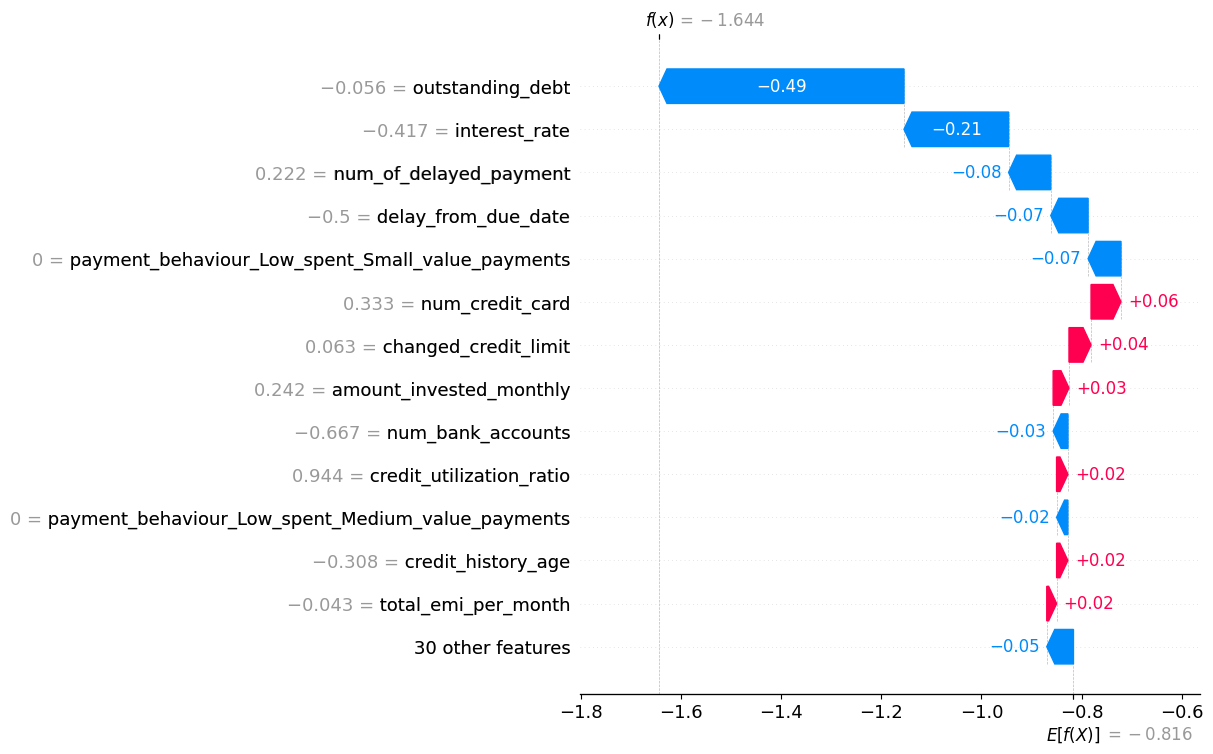

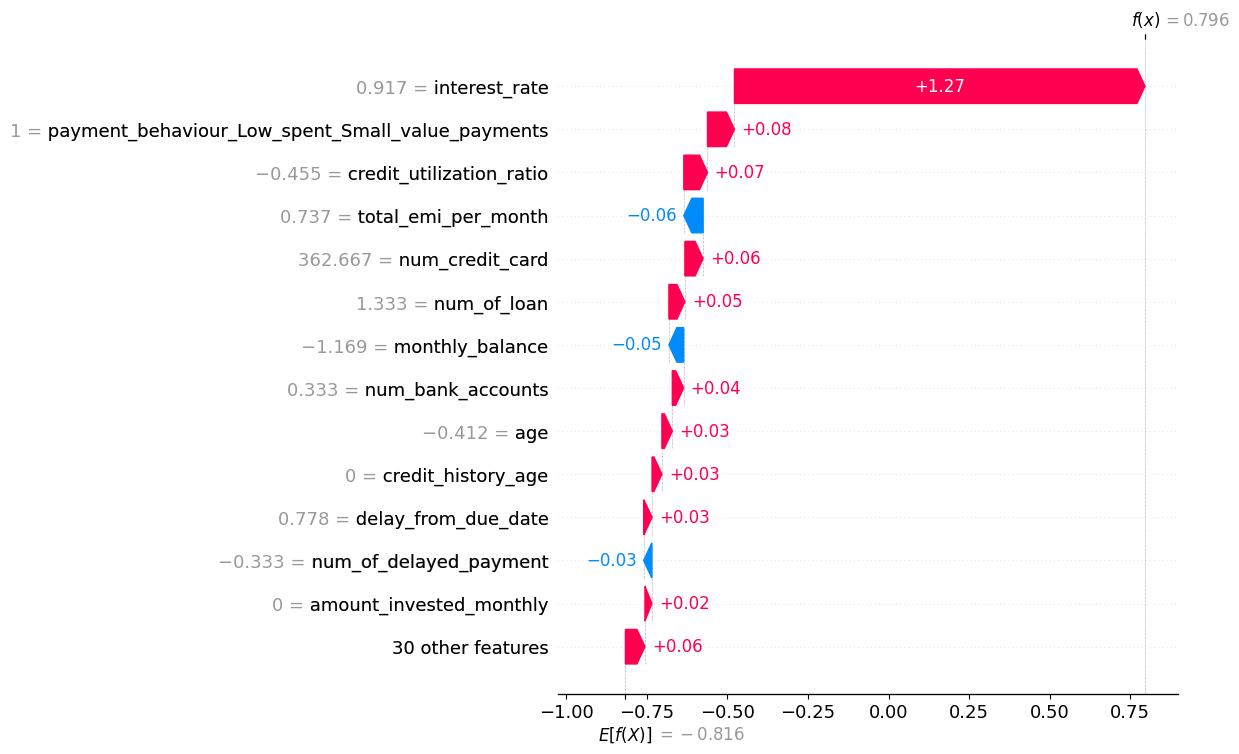

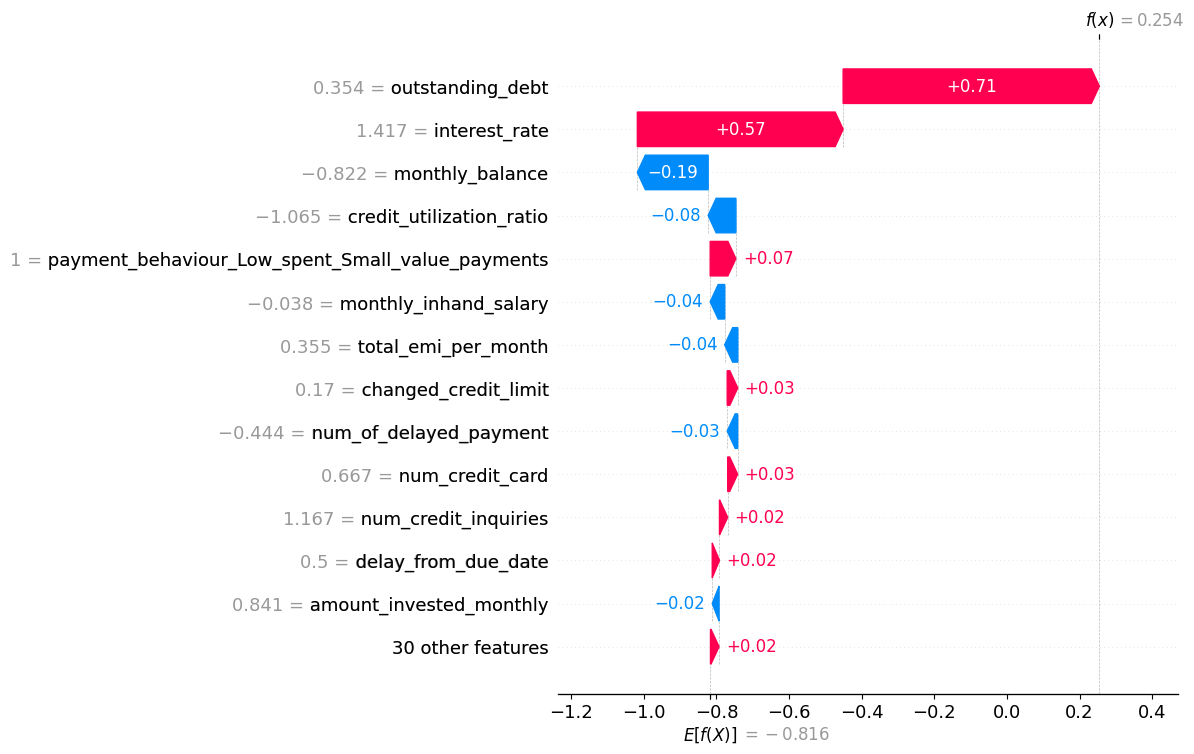

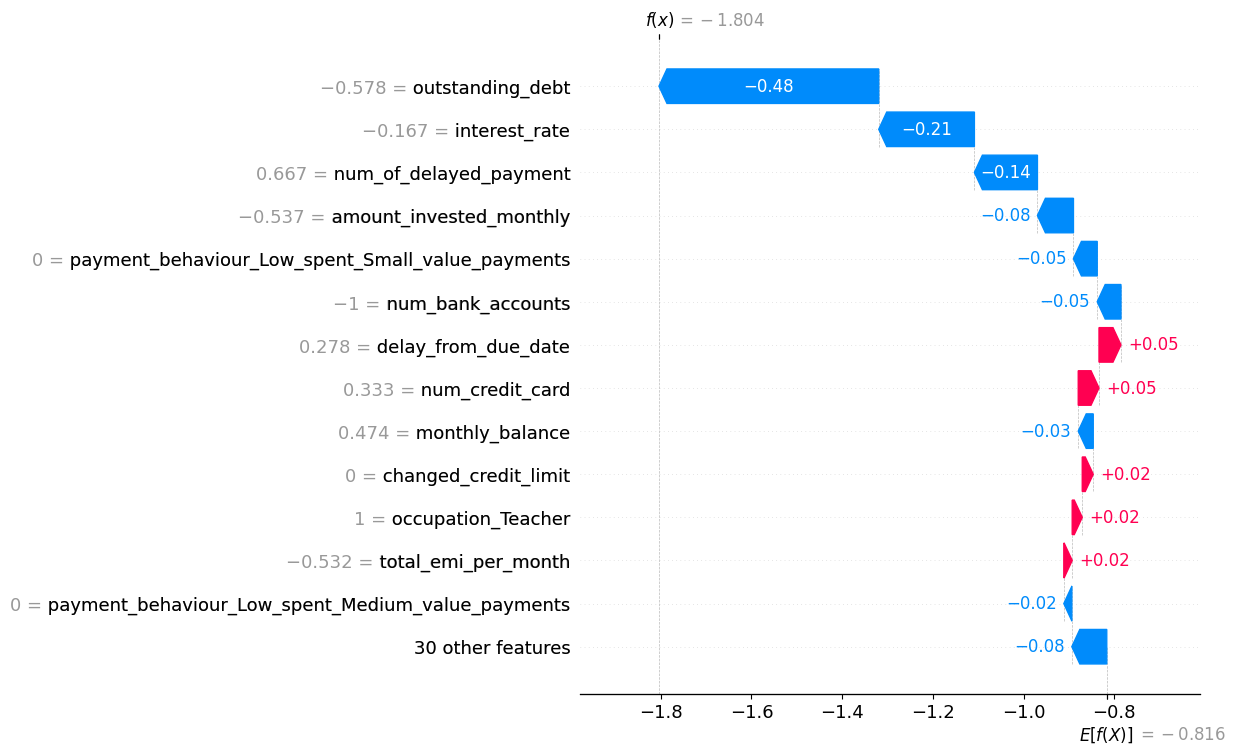

In [59]:
random_indices = random.sample(range(len(X_train_preprocessed)), 10)

for idx in random_indices:
    shap.plots.waterfall(shap_values[idx,:], 
                        max_display=14)